<a href="https://colab.research.google.com/github/maceteligolden/Best-README-Template/blob/master/OffensiveWordsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
!pip install gensim


Importing all necessary libaries

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error,r2_score,classification_report,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import model_selection, svm
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import scale,StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import codecs
import glob
import os
import random
import pandas as pd
import numpy as np
from scipy.sparse import hstack

Downloadding all need nltk packages

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Assigning all global constant to variables

In [3]:
stopwords = set(nltk.corpus.stopwords.words('english'))
training_dataset_path="/content/drive/MyDrive/dataset/olid-training-v1.0.tsv"
testing_dataset_path="/content/drive/MyDrive/dataset/testset-levela.tsv"
testing_label_path="/content/drive/MyDrive/dataset/labels-levela.csv"

Utility functions for removing emojis, cleaning up tweets, plotting graphs, and preprocessing of the dataset

In [36]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_tweets(df):
    tweets = df.loc[:, 'tweet']
    for index, tweet in enumerate(tweets):
      text=re.sub(r'^https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
      text=re.sub('[“"”]',' " ',text)
      text= text.replace("@USER", "")
      text= text.replace("URL", "")
      text = remove_emojis(text)
      text = text.translate(str.maketrans('', '', string.punctuation))
      tweets[index] = text

def plot_classes(df,col_name):
    fig = plt.figure(figsize=(6,4))
    print(df.groupby(col_name)[col_name].count())
    df.groupby(col_name)[col_name].count().plot.bar(ylim=0)
    plt.show()

def preprocess(df):
    tweets = df.loc[:, 'tweet']
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for index, tweet in enumerate(tweets):
        words = nltk.word_tokenize(tweet)
        words = [word for word in words if word.lower() not in stop_words]
        tweets[index] = ' '.join(words)


Extracting training tweets and labels from training data set

                                               tweet
0  @USER She should ask a few native Americans wh...
1  @USER @USER Go home you’re drunk!!! @USER #MAG...
2  Amazon is investigating Chinese employees who ...
3  @USER Someone should'veTaken" this piece of sh...
4  @USER @USER Obama wanted liberals &amp; illega... 

  subtask_a
0       OFF
1       OFF
2       NOT
3       OFF
4       NOT 

Training set class distribution:
label
NOT    8840
OFF    4400
Name: label, dtype: int64


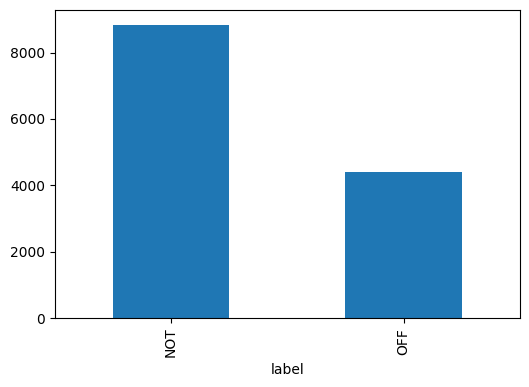



Test set class distribution:
label
NOT    620
OFF    240
Name: label, dtype: int64


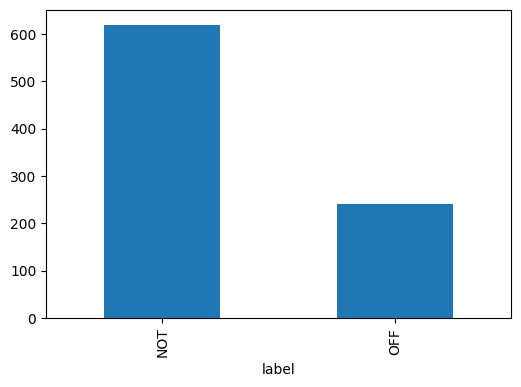

<ipython-input-36-3bf08a6dd483>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets[index] = text


Sample of cleaned tweets
                                               tweet
0   She should ask a few native Americans what th...
1             Go home you’re drunk  MAGA Trump2020  
2  Amazon is investigating Chinese employees who ...
3   Someone shouldveTaken   this piece of shit to...
4    Obama wanted liberals amp illegals to move i...




<ipython-input-36-3bf08a6dd483>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets[index] = ' '.join(words)


Sample of preprocessed tweets
                                               tweet
0                          ask native Americans take
1                     Go home ’ drunk MAGA Trump2020
2  Amazon investigating Chinese employees selling...
3           Someone shouldveTaken piece shit volcano
4  Obama wanted liberals amp illegals move red st...




Training and evaluating SVM with TF-IDF features and Grid Search...
Best parameters for SVM: {'classifier__C': 1, 'classifier__kernel': 'linear'}
SVM model validation accuracy: 0.7617
Validation classification report:
              precision    recall  f1-score   support

         NOT       0.76      0.92      0.84      1733
         OFF       0.76      0.46      0.57       915

    accuracy                           0.76      2648
   macro avg       0.76      0.69      0.70      2648
weighted avg       0.76      0.76      0.74      2648

SVM model test accuracy: 0.8174
Test classification report:
              precision    recall  f1-score

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__max_iter': 100}
Logistic Regression model validation accuracy: 0.7568
Validation classification report:
              precision    recall  f1-score   support

         NOT       0.75      0.95      0.84      1733
         OFF       0.80      0.40      0.53       915

    accuracy                           0.76      2648
   macro avg       0.77      0.67      0.68      2648
weighted avg       0.77      0.76      0.73      2648

Logistic Regression model test accuracy: 0.8140
Test classification report:
              precision    recall  f1-score   support

         NOT       0.83      0.94      0.88       620
         OFF       0.76      0.49      0.59       240

    accuracy                           0.81       860
   macro avg       0.79      0.71      0.74       860
weighted avg       0.81      0.81      0.80       860





In [37]:
if __name__ == "__main__":
    # Read test and training data
    train_data = pd.read_csv(training_dataset_path, delimiter='\t', encoding='utf-8')
    test_tweet_a = pd.read_csv(testing_dataset_path, delimiter='\t', encoding='utf-8')
    test_label_a = pd.read_csv(testing_label_path, encoding='utf-8', index_col=False, names=['id', 'label'])

    # Extract training tweets and labels from training data
    train_tweets = train_data[['tweet']]
    print(train_tweets.head(), "\n")
    train_task_label = train_data[['subtask_a']]
    print(train_task_label.head(), "\n")
    train_task_label.columns = ['label']


    # Extract test tweets and labels from test data
    train_task_a_data = pd.concat([train_tweets, train_task_label], axis=1)
    test_tweet_a = test_tweet_a.merge(test_label_a, on='id').drop(columns='id')

    # Plot class distribution in training set
    print(f"Training set class distribution:")
    plot_classes(train_task_a_data, "label")
    print("\n")
    print(f"Test set class distribution:")
    plot_classes(test_tweet_a, "label")
    print("\n")

    # Clean and preprocess training tweets in training set
    clean_tweets(train_tweets)
    print(f"Sample of cleaned tweets")
    print(train_tweets.head())
    print("\n")
    preprocess(train_tweets)
    print(f"Sample of preprocessed tweets")
    print(train_tweets.head())
    print("\n")

    # Clean and preprocess test tweets in test set
    clean_tweets(test_tweet_a)
    preprocess(test_tweet_a)

    # Combine tweets with labels
    test_tweet_a = test_tweet_a[['tweet', 'label']]

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_task_a_data['tweet'], train_task_a_data['label'], test_size=0.2, random_state=42)

    # Initialize classifiers and their parameter grids for GridSearchCV
    param_grids = {
        'SVM': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
        },
        'Naive Bayes': {
            'classifier__alpha': [0.1, 0.5, 1.0],
        },
        'Random Forest': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20],
        },
        'Logistic Regression': {
            'classifier__C': [0.1, 1, 10],
            'classifier__max_iter': [100, 200, 500],
        }
    }

    classifiers = {
        'SVM': SVC(),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42)
    }

    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')

    # Feature extraction with TF-IDF
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(test_tweet_a['tweet'])

    # Train and evaluate classifiers with TF-IDF features using GridSearchCV
    for name, clf in classifiers.items():
        print("\n")
        print(f"Training and evaluating {name} with TF-IDF features and Grid Search...")
        pipeline = Pipeline([
            ('classifier', clf)
        ])
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train_tfidf, y_train)

        print(f"Best parameters for {name}: {grid_search.best_params_}")

        # Evaluate on validation set
        y_val_pred = grid_search.predict(X_val_tfidf)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        print(f"{name} model validation accuracy: {val_accuracy:.4f}")
        print("Validation classification report:")
        print(classification_report(y_val, y_val_pred))

        # Evaluate on test set
        y_test_pred = grid_search.predict(X_test_tfidf)
        test_accuracy = accuracy_score(test_tweet_a['label'], y_test_pred)
        print(f"{name} model test accuracy: {test_accuracy:.4f}")
        print("Test classification report:")
        print(classification_report(test_tweet_a['label'], y_test_pred))
        print("\n")
